## Imports

### Install packages

In [24]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet jupyterlab-vim)"
!jupyter labextension enable

In [25]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet graphviz)"

In [ ]:
!sudo /bin/bash -c "(source /venv/bin/activate; pip install --quiet dataframe_image)"

### Import modules

In [26]:
%load_ext autoreload
%autoreload 2

import logging

import arviz as az
import pandas as pd
import xarray as xr
import pymc as pm
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import preliz as pz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
dir_name = "./Lesson07-data"

!ls $dir_name

anscombe.csv	     chemical_shifts_theo_exp.csv  islands.csv
anscombe_3.csv	     coal.csv			   penguins.csv
babies.csv	     dummy.csv			   pigs.csv
bikes.csv	     fish.csv			   redwood.csv
bikes_full.csv	     football_players.csv	   space_flu.csv
body_fat.csv	     horseshoe_crab.csv		   tips.csv
body_fat_full.csv    howell.csv
chemical_shifts.csv  iris.csv


In [28]:
import msml610_utils as ut

ut.config_notebook()

# Setting notebook style
# Notebook signature
Python 3.12.3
Linux 8611c84637c0 6.10.14-linuxkit #1 SMP Tue Apr 15 16:00:54 UTC 2025 aarch64 aarch64 aarch64 GNU/Linux
numpy version=1.26.4
pymc version=5.18.2
matplotlib version=3.10.3
arviz version=0.21.0
preliz version=0.19.0


# Chap1: Thinking probabilistically

## Binomial

In [29]:
#help(pz.Binomial.plot_interactive)

In [30]:
np.random.seed(42)

# Create a Normal Gaussian.
n = 8
#p = 0.25
p = 0.01
X = stats.binom(n, p)

# Print 3 realizations.
x = X.rvs(n)
print(x)

[0 1 0 0 0 0 0 0]


(3, 5)
![](/app/lectures_source/figures/Binomial_distribution.png){ width=100px }


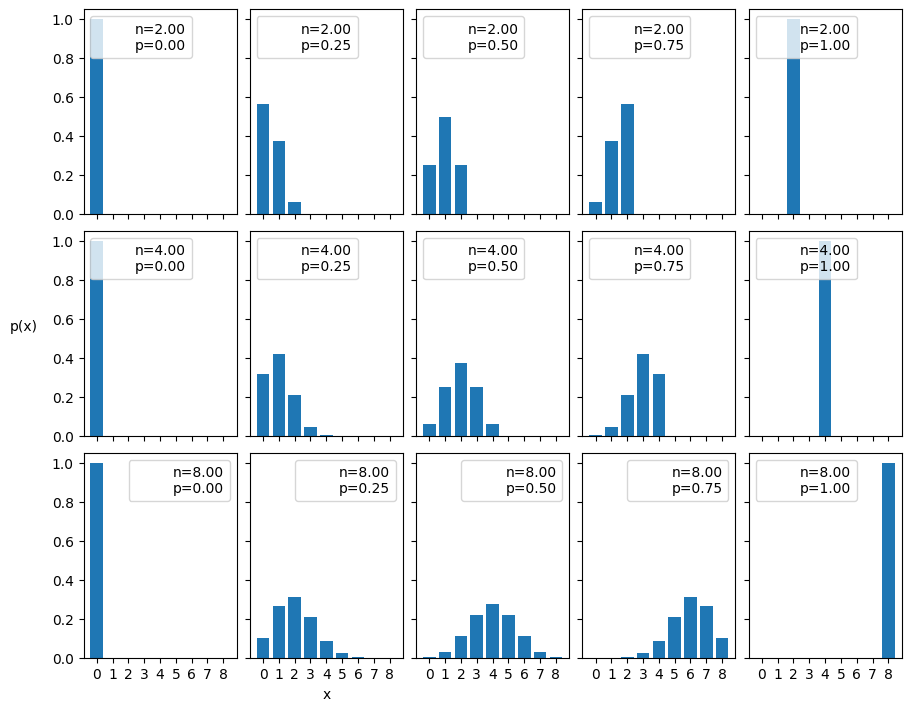

In [31]:
ut.plot_binomial()

In [32]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

# Probability of k successes on N trial flipping a coin with p success
pz.Binomial(p=0.5, n=5).plot_interactive(**params)

interactive(children=(IntSlider(value=5, description='n (0, inf)', max=15, style=SliderStyle(description_width…

## Beta

- Continuous prob distribution defined in [0, 1]
- It is useful to model probability or proportion
    - E.g., the probability of success in a Bernoulli trial

- alpha represents "success" parameter
- beta represents "failure" parameter
    - When alpha is larger than beta the distribution skews toward 1, indicating a higher probability of success
    - When alpha = beta the distribution is symmetric and centered around 0.5

In [33]:
np.random.seed(123)

trials = 4
# Unknown value.
theta_real = 0.35

# Generate some values.
data = stats.bernoulli.rvs(p=theta_real, size=trials)
print(data)

[1 0 0 0]


![](/app/lectures_source/figures/Chap7_Beta_distribution.png){ width=100px }


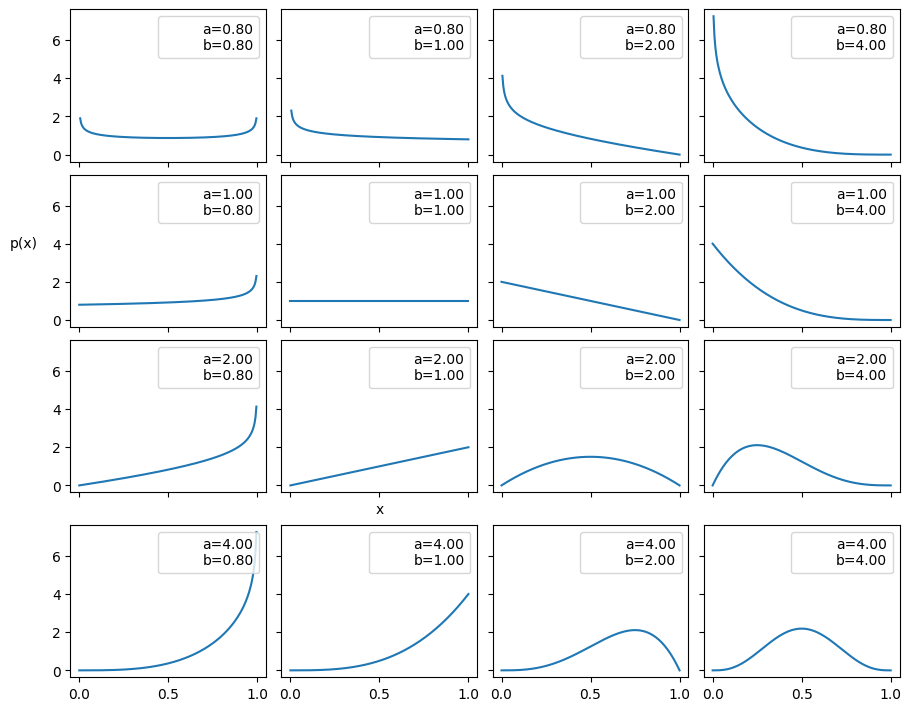

In [34]:
ut.plot_beta()

In [35]:
params = {
    #"kind": "cdf",
    "kind": "pdf",
    "pointinterval": False,
    "interval": "hdi",   # Highest density interval.
    #"interval": "eti",  # Equal tailed interval.
    "xy_lim": "auto"
}

alpha = 3.0
beta = 1.0

pz.Beta(alpha=alpha, beta=beta).plot_interactive(**params)

interactive(children=(FloatSlider(value=3.0, description='alpha (0, inf)', max=13.0, min=2.220446049250313e-16…

# Coin problem: analytical solution

![](/app/lectures_source/figures/Chap7_Updating_the_prior.png){ width=100px }


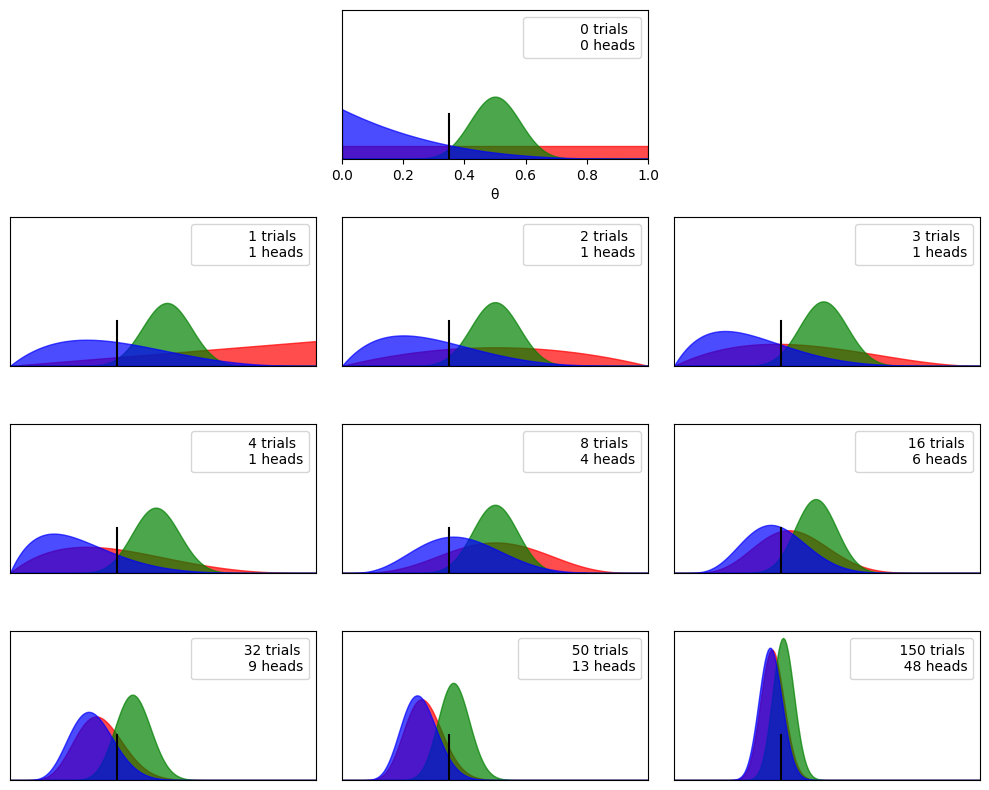

In [36]:
ut.update_prior()

In [37]:
from IPython.display import Code
import inspect
func = ut.update_prior
code = inspect.getsource(func)
#display(Code(code))

In [38]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
from IPython.core.display import HTML

formatter = HtmlFormatter(style="default", full=True, cssclass="codehilite")
highlighted_code = highlight(code, PythonLexer(), formatter)
display(HTML(highlighted_code))

## Coin problem: PyMC solution

In [39]:
np.random.seed(123)
n = 4
# Unknown value.
theta_real = 0.35

# Generate some observational data.
data1 = stats.bernoulli.rvs(p=theta_real, size=n)
data1

array([1, 0, 0, 0])

In [40]:
with pm.Model() as model1:
    # Prior.
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # Likelihood.
    y = pm.Bernoulli('y', p=theta, observed=data1)
    # (Numerical) Inference to estimate the posterior distribution through samples.
    idata1 = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


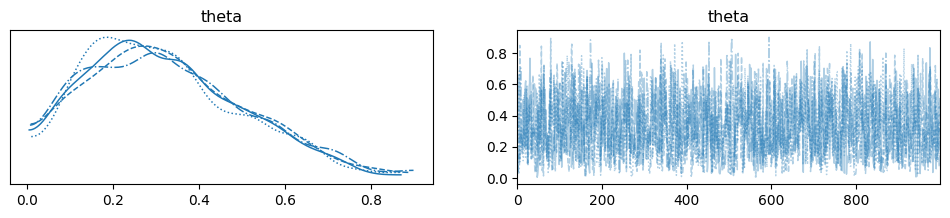

In [41]:
az.plot_trace(idata1);

In [42]:
#?az.summary

In [43]:
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.324,0.179,0.031,0.653


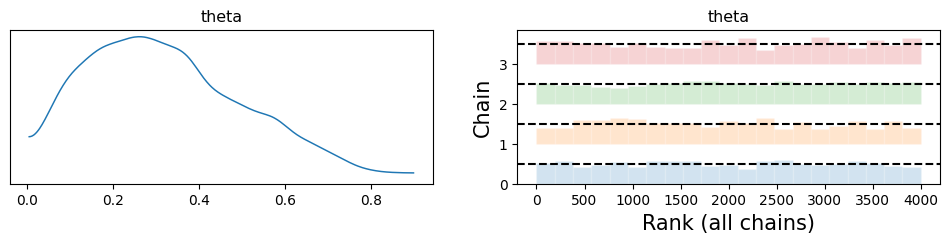

In [44]:
az.plot_trace(idata1, kind="rank_bars", combined=True);

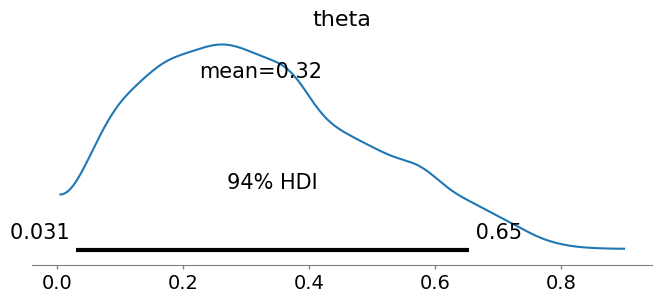

In [45]:
az.plot_posterior(idata1);

## More data

In [46]:
np.random.seed(123)
n = 20
# Unknown value.
theta_real = 0.35

# Generate some observational data.
data2 = stats.bernoulli.rvs(p=theta_real, size=n)
data2

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0])

In [47]:
with pm.Model() as model2:
    # Prior.
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # Likelihood.
    y = pm.Bernoulli('y', p=theta, observed=data2)
    # (Numerical) Inference to estimate the posterior distribution through samples.
    idata2 = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [48]:
az.summary(idata2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.32,0.098,0.147,0.507


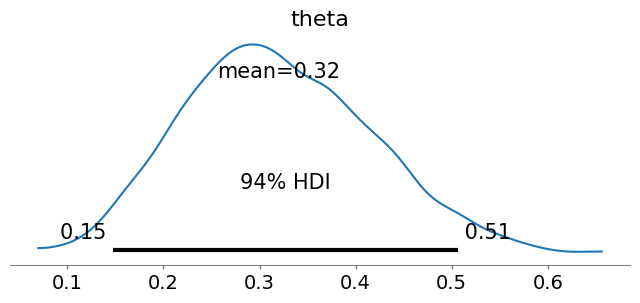

In [49]:
az.plot_posterior(idata2);

## Even more data

In [50]:
np.random.seed(123)
n = 100
# Unknown value.
theta_real = 0.35

# Generate some observational data.
data3 = stats.bernoulli.rvs(p=theta_real, size=n)
data3

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [51]:
with pm.Model() as model3:
    # Prior.
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # Likelihood.
    y = pm.Bernoulli('y', p=theta, observed=data3)
    # (Numerical) Inference to estimate the posterior distribution through samples.
    idata3 = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [52]:
az.summary(idata3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
theta,0.303,0.047,0.218,0.391


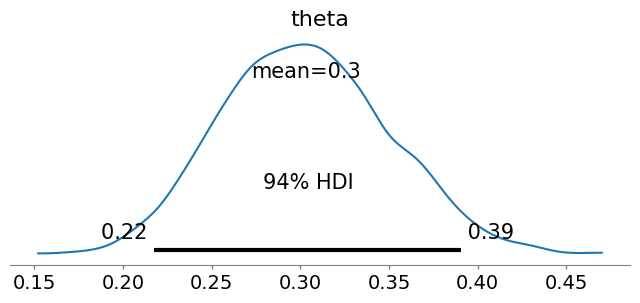

In [53]:
az.plot_posterior(idata3);

## Savage-Dickey ratio

arviz - WARNING - The reference value is outside of the posterior. This translate into infinite support for H1, which is most likely an overstatement.


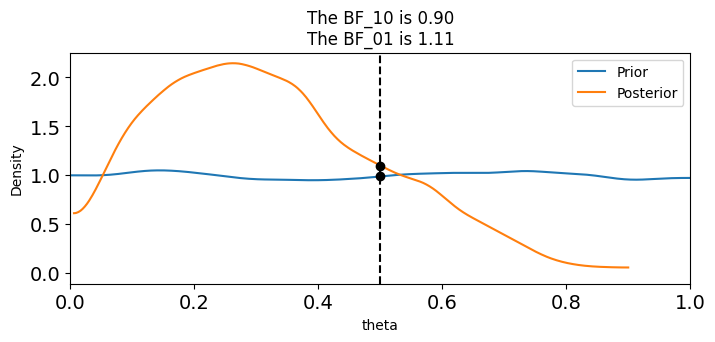

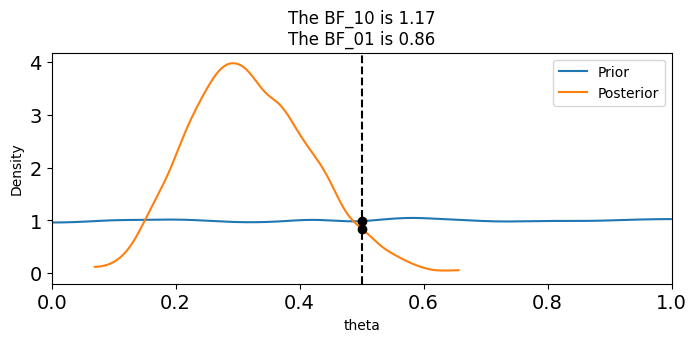

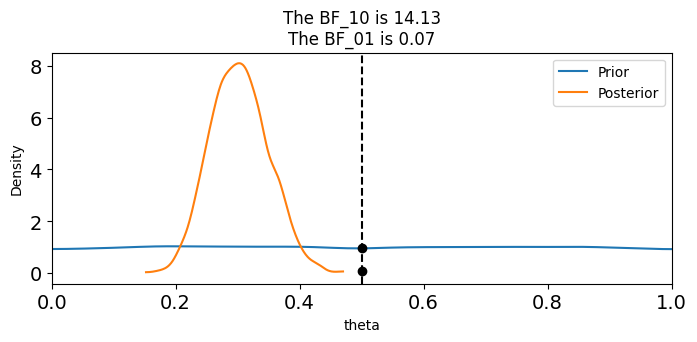

In [54]:
for idata in [idata1, idata2, idata3]:
    az.plot_bf(idata, var_name="theta", prior=np.random.uniform(0, 1, 10000), ref_val=0.5);
    plt.xlim(0, 1);

## ROPE

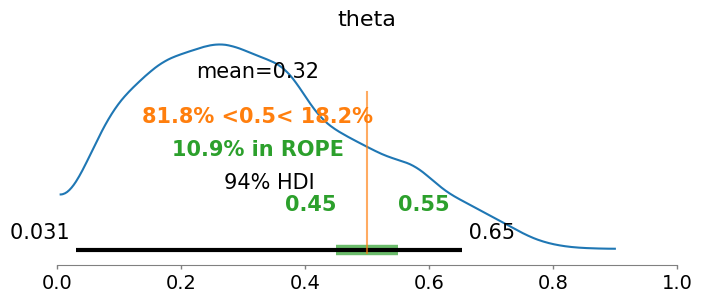

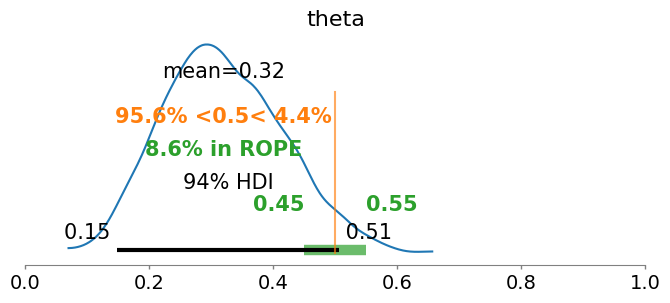

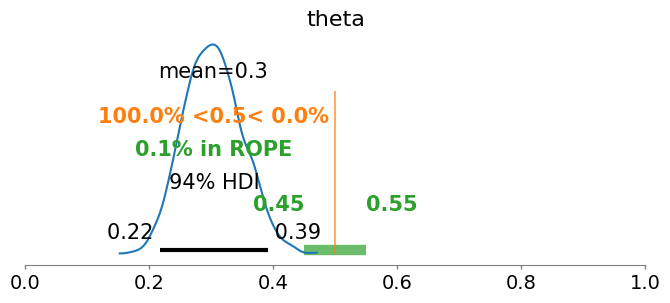

In [55]:
for idata in [idata1, idata2, idata3]:
    az.plot_posterior(idata, rope=[0.45, .55], ref_val=0.5)
    plt.xlim(0, 1);

# Decision with loss function

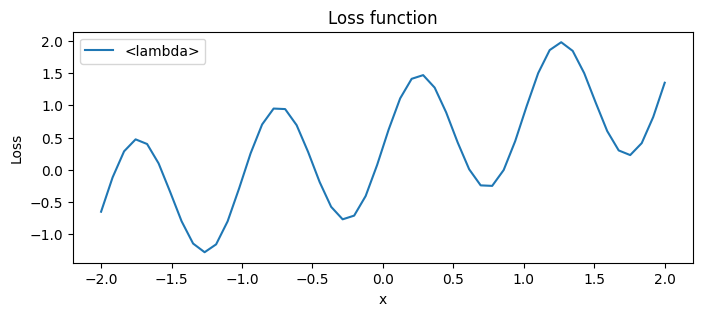

In [56]:
#loss_func = lambda x: ut.squared_loss(x, theta_real)
#loss_func = lambda x: ut.abs_loss(x, theta_real)
#loss_func = lambda x: ut.asymmetric_loss(x, theta_real)
loss_func = lambda x: ut.sin_loss(x, theta_real)

grid = np.linspace(-2.0, 2.0, 50)
ut.plot_loss(grid, loss_func)

In [57]:
idata1.to_dataframe()[("posterior", "theta")]

0       0.145339
1       0.146737
2       0.040329
3       0.109264
4       0.129498
          ...   
3995    0.369080
3996    0.360284
3997    0.073147
3998    0.087704
3999    0.147956
Name: (posterior, theta), Length: 4000, dtype: float64

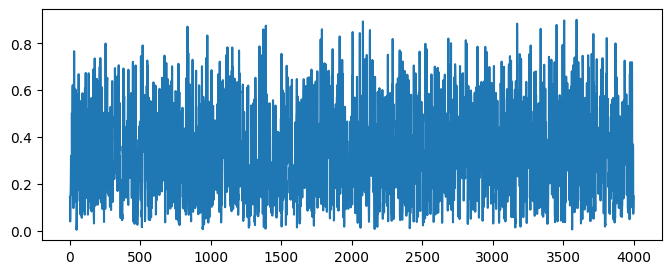

In [58]:
plt.plot(idata1.to_dataframe()[("posterior", "theta")]);

<Axes: ylabel='Density'>

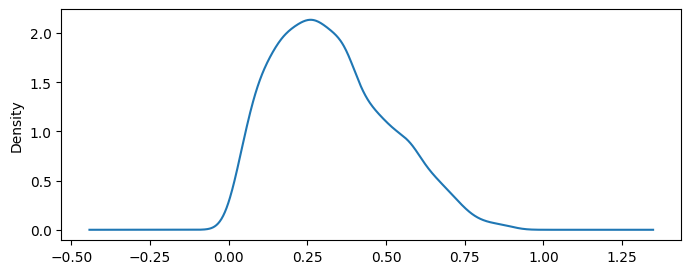

In [59]:
df = idata1.to_dataframe()[("posterior", "theta")]
df.plot(kind="kde")

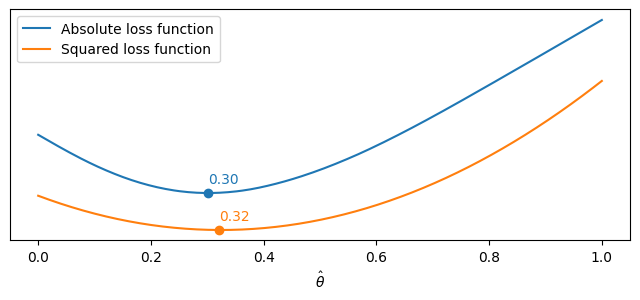

In [60]:
ut.pick_best_theta(idata1)

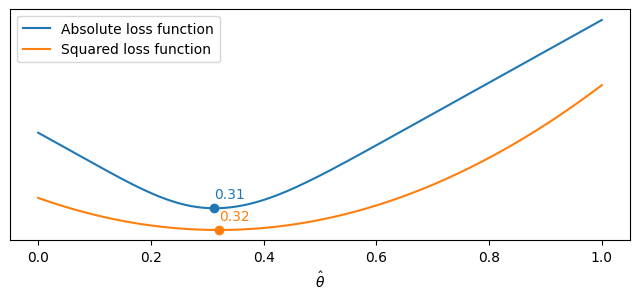

In [61]:
ut.pick_best_theta(idata2)

# Gaussian inference

48 [51.06 55.12 53.73 50.24 52.05 56.4  48.45 52.34 55.65 51.49 51.86 63.43
 53.   56.09 51.93 52.31 52.33 57.48 57.44 55.14 53.93 54.62 56.09 68.58
 51.36 55.47 50.73 51.94 54.95 50.39 52.91 51.5  52.68 47.72 49.73 51.82
 54.99 52.84 53.19 54.52 51.46 53.73 51.61 49.81 52.42 54.3  53.84 53.16]
![](/app/lectures_source/figures/Chap7_Chemical_shift.png){ width=100px }


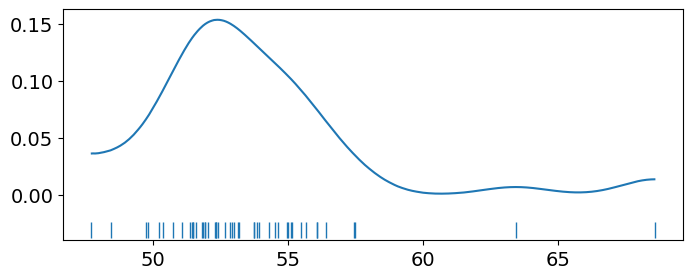

In [62]:
data = np.loadtxt(f"{dir_name}/chemical_shifts.csv")
print(len(data), data)
#print(sorted(data))

# It looks Gaussian with a couple of outliers.
az.plot_kde(data, rug=True)

title = "Chap7: Chemical shift"
ut.process_figure(title);

In [63]:
with pm.Model() as model_g:
    # The mean is Uniform in [40, 70] (which is larger than the data).
    mu = pm.Uniform("mu", lower=40, upper=70)
    # The std dev is half normal with a large value (which is a large value based on the data).
    sigma = pm.HalfNormal("sigma", sigma=10)
    # The model is N(mu, sigma).
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data)
    # Sample.
    idata_g = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


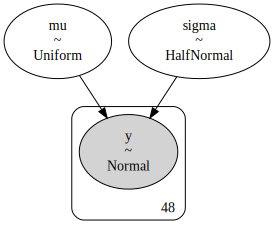

In [64]:
pm.model_to_graphviz(model_g)

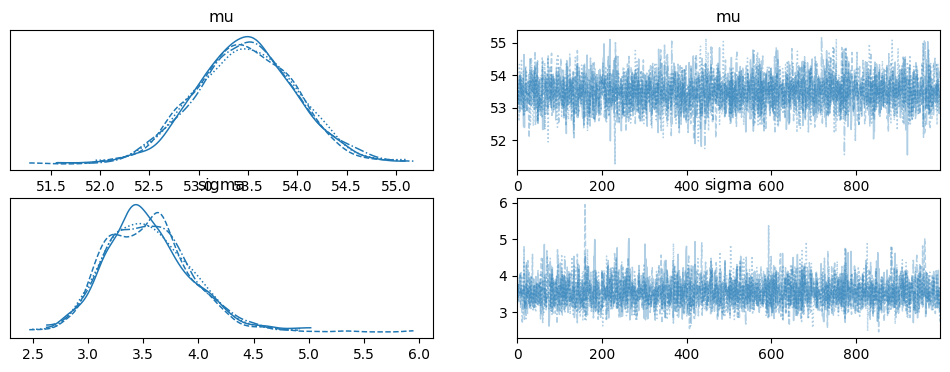

In [65]:
# There are 4 traces for 2 variables.
az.plot_trace(idata_g);

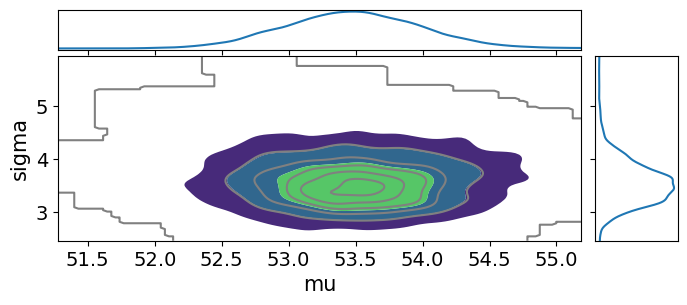

In [66]:
# The posterior distribution of the params is bi-dimensional, since it has mu and sigma.
az.plot_pair(idata_g, kind='kde', marginals=True);

In [67]:
# Report a summary of the inference.
az.summary(idata_g, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,53.48,0.51,52.49,54.39
sigma,3.55,0.38,2.91,4.30


In [68]:
# Compute 100 posterior predictive samples.
y_pred_g = pm.sample_posterior_predictive(idata_g, model=model_g)

Sampling: [y]


Output()

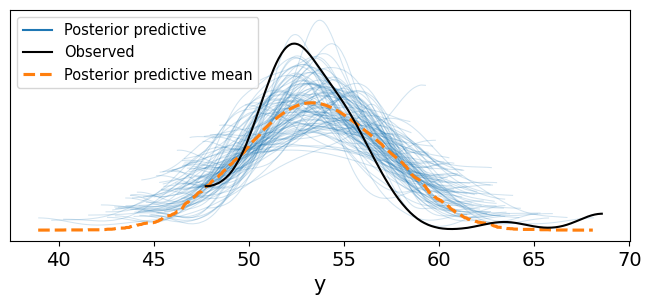

In [69]:
# Black: KDE of the data (observed)
# Blue: KDEs of the posterior predictive samples
# Orange: KDE of the posterior predictive mean
az.plot_ppc(y_pred_g, mean=True, num_pp_samples=100);

In [70]:
# Student-t

![](/app/lectures_source/figures/Chap7_Student-t.png){ width=100px }


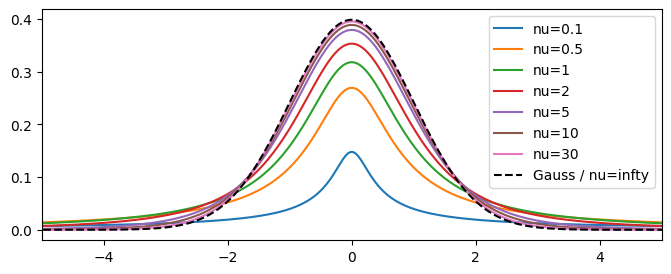

In [71]:
# Show the PDF for various values of \nu.

# Points to be used to sample the PDF.
x_values = np.linspace(-10, 10, 500)

# Plot t-student sweeping \nu.
for df in [0.1, 0.5, 1, 2, 5, 10, 30]:
    # Student-t with df.
    distr = stats.t(df)
    # Compute PDF.
    x_pdf = distr.pdf(x_values)
    plt.plot(x_values, x_pdf, label=f"nu={df}")
    
# Plot gaussian.
x_pdf = stats.norm.pdf(x_values)
plt.plot(x_values, x_pdf, "k--", label="Gauss / nu=infty")

plt.xlim(-5, 5) 
plt.legend();

title = "Chap7: Student-t"
ut.process_figure(title);

In [72]:
# Use a Student-T model.
with pm.Model() as model_t:
    mu = pm.Uniform("mu", 40, 75)
    sigma = pm.HalfNormal("sigma", sigma=10)
    # A student with nu = 30 is close to a Gaussian.
    nu = pm.Exponential("nu", 1/30)
    #
    y = pm.StudentT("y", mu=mu, sigma=sigma, nu=nu, observed=data)
    idata_t = pm.sample(1_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


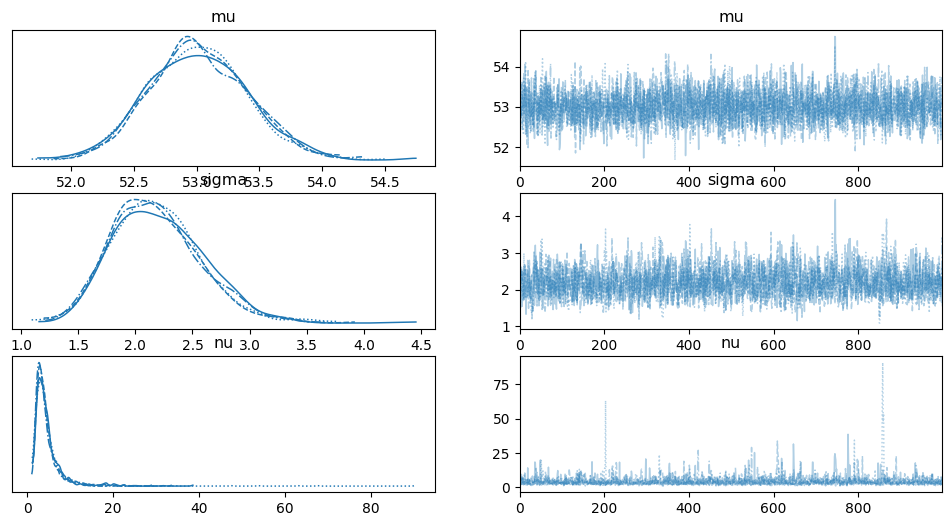

In [73]:
az.plot_trace(idata_t);

In [74]:
az.summary(idata_t, kind="stats").round(2)

,mean,sd,hdi_3%,hdi_97%
mu,53.01,0.39,52.34,53.79
sigma,2.19,0.39,1.55,2.96
nu,4.54,3.69,1.18,9.11


In [75]:
# Compute 100 posterior predictive samples.
y_ppc_t = pm.sample_posterior_predictive(idata_t, model_t);

Sampling: [y]


Output()

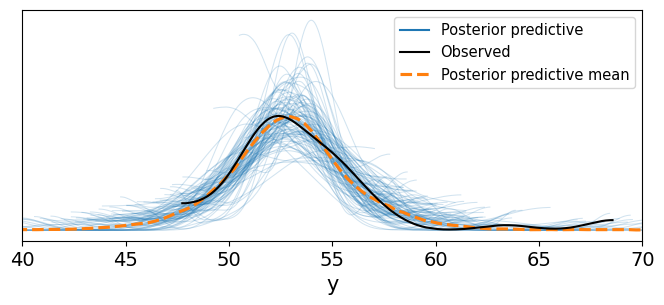

In [76]:
ax = az.plot_ppc(y_ppc_t, num_pp_samples=100, mean=True)
ax.set_xlim(40, 70);

# Group comparison

In [77]:
import pandas as pd
import seaborn as sns
import pprint

In [78]:
tips = pd.read_csv(dir_name + '/tips.csv')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


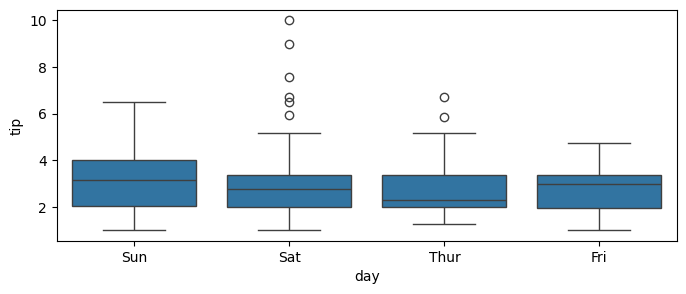

In [79]:
sns.boxplot(x='day', y='tip', data=tips);

In [80]:
# Extract the tips.
tip = tips['tip'].values
print(tip[:10])

# Create a vector going from day to group idx.
idx = pd.Categorical(tips['day']).codes
print("idx=", idx)

# Count the groups.
groups = np.unique(idx)
n_groups = len(groups)
print("groups=", n_groups, groups)

[1.01 1.66 3.5  3.31 3.61 4.71 2.   3.12 1.96 3.23]
idx= [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3]
groups= 4 [0 1 2 3]


In [81]:
# The model is the same as before but it can be easily vectorized.
# There is no need to write a for-loop.
with pm.Model() as comparing_groups:
    # mu is a vector of 4 elems.
    mu = pm.Normal('mu', mu=0, sigma=10, shape=n_groups)
    # sigma is a vector of 4 elems.
    sigma = pm.HalfNormal("sigma", sigma=10, shape=n_groups)
    # y is a vector of 4 normals each with mean and sigma for the group.
    y = pm.Normal('y', mu=mu[idx], sigma=sigma[idx], observed=tip)
    idata_cg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 3 seconds.


# Hierarchical models

In [82]:
cs_data = pd.read_csv(dir_name + '/chemical_shifts_theo_exp.csv')
cs_data["diff"] = cs_data["theo"] - cs_data["exp"]
display(cs_data)

,ID,aa,theo,exp,cat,diff
0,1BM8,ILE,61.18,58.27,Non-Polar,2.91
1,1BM8,TYR,56.95,56.18,Polar,0.77
2,1BM8,SER,56.35,56.84,Polar,-0.49
3,1BM8,ALA,51.96,51.01,Special,0.95
4,1BM8,ARG,56.54,54.64,Charged,1.90
...,...,...,...,...,...,...
1771,1KS9,LYS,55.79,57.51,Charged,-1.72
1772,1KS9,ARG,58.91,59.02,Charged,-0.11
1773,1KS9,LYS,59.49,58.92,Charged,0.57
1774,1KS9,GLU,59.48,58.36,Charged,1.12


In [83]:
diff = cs_data.theo.values - cs_data.exp.values
print("diff=", diff)

# Array of categorical values.
cat_encode = pd.Categorical(cs_data['aa'])
print("cat_encode=", cat_encode)
idx = cat_encode.codes
print("idx=", len(idx), idx)
coords = {"aa": cat_encode.categories}
print("coords=", coords)

diff= [ 2.91  0.77 -0.49 ...  0.57  1.12 -2.48]
cat_encode= ['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']
idx= 1776 [ 8 17 14 ... 10  5 14]
coords= {'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
       'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
      dtype='object')}


In [84]:
# Non-hierarchical model.
with pm.Model(coords=coords) as cs_nh:
    # One separate prior for each group.
    mu = pm.Normal('mu', mu=0, sigma=10, dims="aa")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="aa")
    # Likelihood.
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


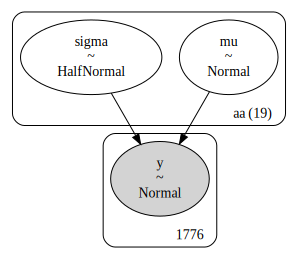

In [85]:
pm.model_to_graphviz(cs_nh)

In [86]:
with pm.Model(coords=coords) as cs_h:
    # Hyper-priors.
    mu_mu = pm.Normal("mu_mu", mu=0, sigma=10)
    mu_sigma = pm.HalfNormal("mu_sigma", sigma=10)
    
    # Priors.
    mu = pm.Normal("mu", mu=mu_mu, sigma=mu_sigma, dims="aa")
    sigma = pm.HalfNormal("sigma", sigma=10, dims="aa")
    
    # Likelihood (same as before).
    y = pm.Normal("y", mu=mu[idx], sigma=sigma[idx], observed=diff)
    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mu, mu_sigma, mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


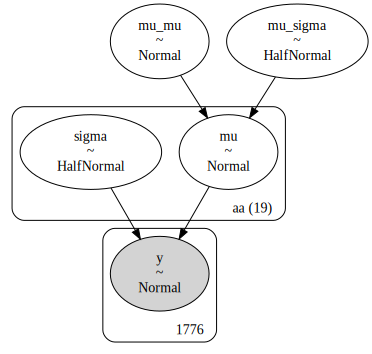

In [87]:
pm.model_to_graphviz(cs_h)

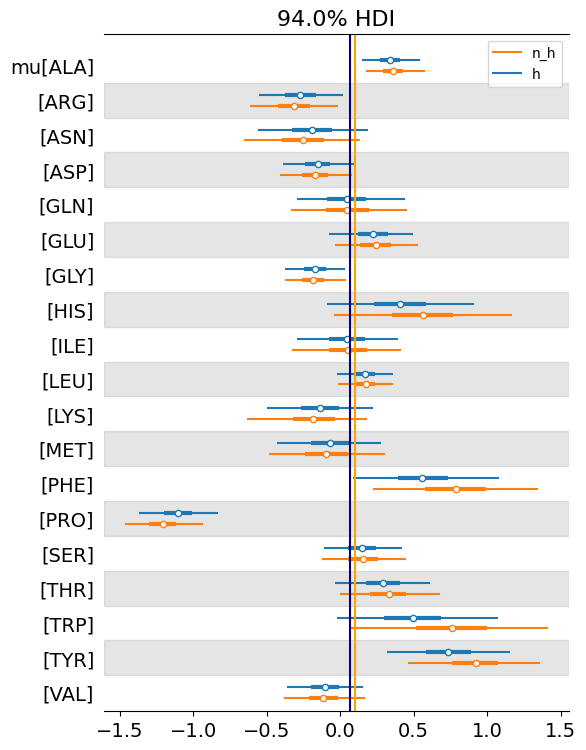

In [88]:
# We have two models and we want to compare the estimates.
# - There are 20 groups and each model has 4 estimates.
# - We plot the 94% credible intervals.
# - The vertical line is the global mean according to the hierarchical model.
# - The blue (hierarchical) means are pulled towards the mean, wrt the orange (non-hierarchical) ones.
axes = az.plot_forest([idata_cs_h, idata_cs_nh],
                      model_names=['h', 'n_h'],
                      var_names='mu',
                      combined=True,
                      colors='cycle')

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['mu_mu'].mean(), *y_lims, color='navy')
axes[0].vlines(idata_cs_nh.posterior['mu'].mean(), *y_lims, color='orange');

# Linear regression

## Synthetic example

In [89]:
np.random.seed(1)

# Number of samples.
N = 100

# Parameters.
alpha_real = 2.5
beta_real = 0.9
sigma_eps_real = 0.5

# Generate data.
x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x

# Add noise.
eps_real = np.random.normal(0, sigma_eps_real, size=N)
y = y_real + eps_real

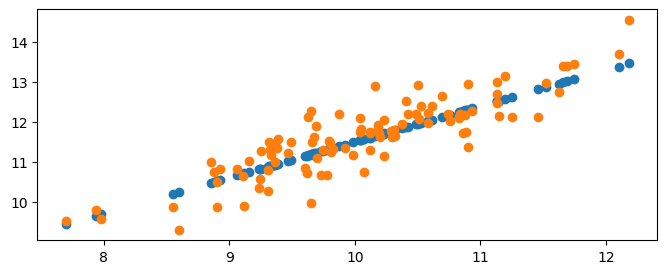

In [90]:
plt.scatter(x, y_real)
plt.scatter(x, y);

<Axes: xlabel='X', ylabel='Y'>

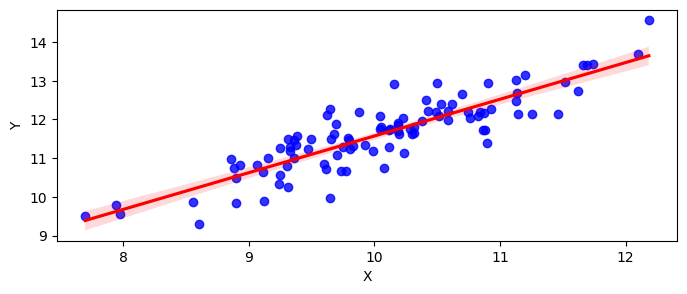

In [91]:
df = pd.DataFrame({"X": x, "Y": y})
sns.regplot(x="X", y="Y", data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})

In [92]:
with pm.Model() as model_g:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", 5)
    #
    mu = pm.Deterministic("mu", alpha + beta * x)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=y)
    idata_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.


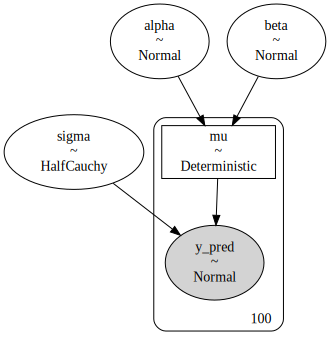

In [93]:
pm.model_to_graphviz(model_g)

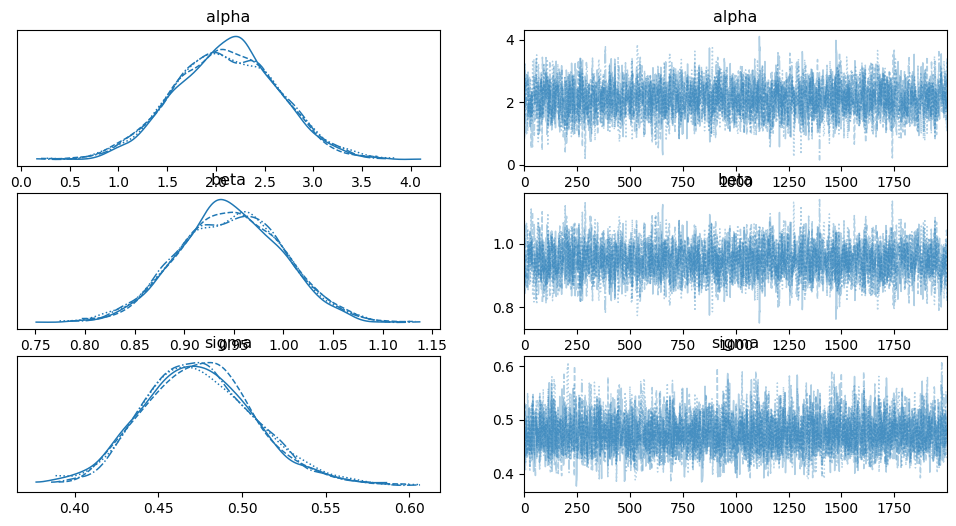

In [94]:
az.plot_trace(idata_g, var_names=["alpha", "beta", "sigma"]);

In [95]:
az.summary(idata_g, var_names="alpha beta sigma".split(), kind="stats")

,mean,sd,hdi_3%,hdi_97%
alpha,2.105,0.537,1.043,3.060
beta,0.947,0.053,0.848,1.047
sigma,0.475,0.034,0.413,0.540


## Bike rental example

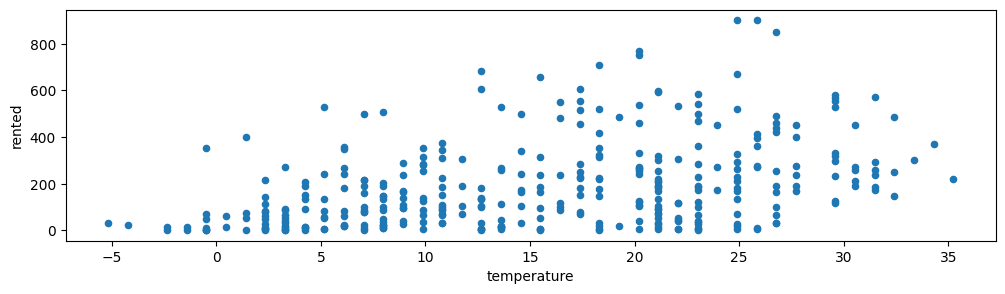

In [96]:
bikes = pd.read_csv(dir_name + "/bikes.csv")
bikes.plot(x="temperature", y="rented", figsize=(12, 3), kind="scatter");

In [97]:
bikes.head()

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0


In [98]:
with pm.Model() as model_lb:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", 10)
    #
    mu = pm.Deterministic("mu", alpha + beta * bikes.temperature)
    #
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=bikes.rented)
    idata_lb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


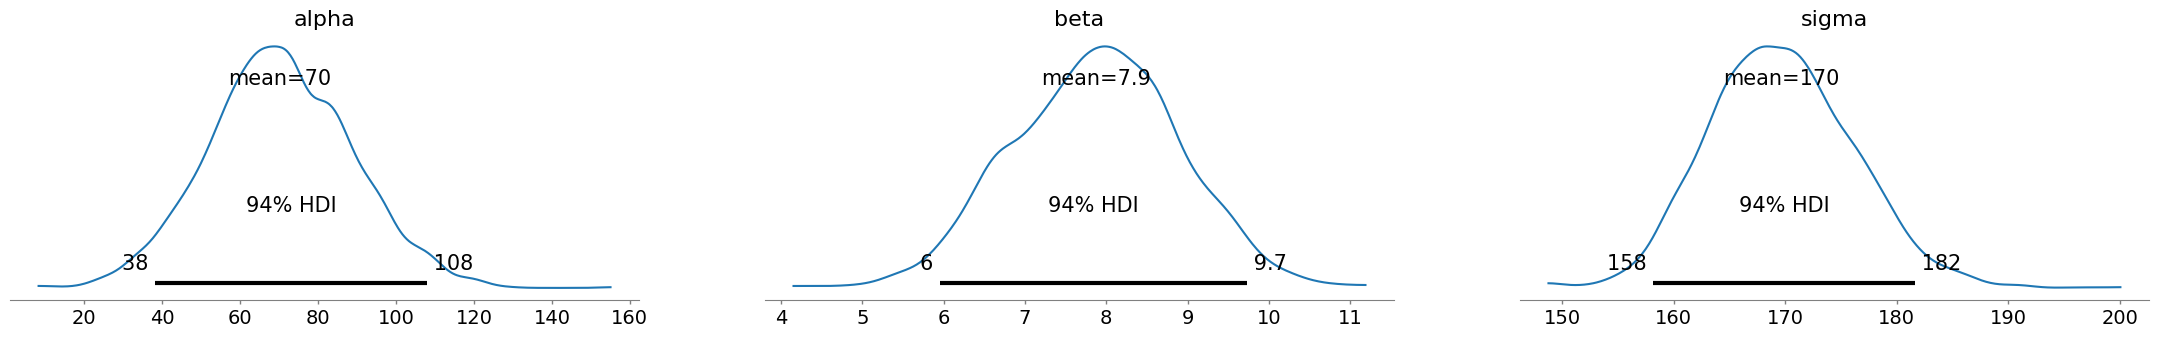

In [99]:
# Plot all the vars, excluding mu.
az.plot_posterior(idata_lb, var_names=["~mu"]);

In [100]:
# Sample from the posterior.
posterior = az.extract(idata_lb, num_samples=50)

In [101]:
# Create a data array of 50 equally-spaced points from min to max temperature along the `plot_id` axis.
x_plot = xr.DataArray(
    np.linspace(bikes.temperature.min(), bikes.temperature.max(), 50), dims="plot_id"
)

# Compute the expected value of the model for the points.
mean_line = posterior["alpha"].mean() + posterior["beta"].mean() * x_plot


# Compute 50 lines using the posterior.
lines = posterior["alpha"] + posterior["beta"] * x_plot

In [102]:
idata_lb_pp = pm.sample_posterior_predictive(idata_lb, model=model_lb)
mean_line = idata_lb.posterior["mu"].mean(("chain", "draw"))

def plot_data_and_model(bikes, idata):
    # Generate a vector with the temperatures and a bit of jitter.
    temperatures = np.random.normal(bikes.temperature.values, 0.01)
    
    # Sort in increasing order.
    idx = np.argsort(temperatures)
    
    # Sample the temperature intervals.
    x = np.linspace(temperatures.min(), temperatures.max(), 15)
    
    # Compute the quantiles, flattening over chain and draw.
    y_pred_q = idata.posterior_predictive["y_pred"].quantile(
        [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"])
    #obj_to_str(y_pred_q, only_schema=False)
    
    from scipy.interpolate import PchipInterpolator
    
    y_hat_bounds = [
            PchipInterpolator(temperatures[idx], y_pred_q[i][idx])(x)
            for i in range(4)
    ]
    #print(y_hat_bounds)
    
    # Plot the data set.
    plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)
    # Plot the mean.
    plt.plot(bikes.temperature[idx], mean_line[idx], c="C0")
    
    # Plot the quantiles.
    lb, ub = y_hat_bounds[0], y_hat_bounds[1]
    plt.fill_between(x, lb, ub, color="C1", alpha=0.2);
    lb, ub = y_hat_bounds[2], y_hat_bounds[3]
    plt.fill_between(x, lb, ub, color="C1", alpha=0.2);

Sampling: [y_pred]


Output()

In [103]:
print(x_plot.shape)

(50,)


In [104]:
print(mean_line.shape)

(348,)


ValueError: x and y must have same first dimension, but have shapes (50,) and (348,)

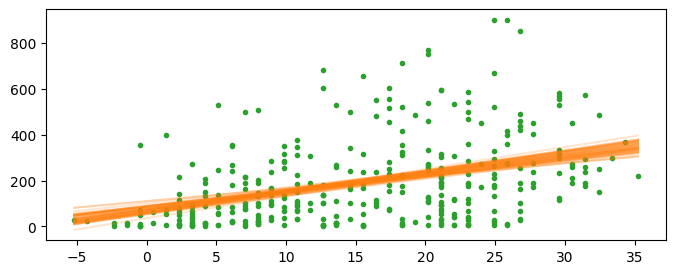

In [105]:
# - Plot the data
# zorder is to plot behind the line.
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3);

# - Plot the 50 models from the posterior.
# lines.T.values are the 50 lines.
lines_ = plt.plot(x_plot, lines.T.values, c="C1", alpha=0.2, label="lines");
# Remove the label for all the lines but the first one.
plt.setp(lines_[1:], label="_")

# Plot the mean line.
plt.plot(x_plot, mean_line, c="C0", label="mean line");

plt.xlabel("temp")
plt.ylabel("rented bikes")

plt.legend();

In [ ]:
plot_data_and_model(bikes, idata_lb_pp)

## Counting

In [ ]:
np.random.seed(42)
with pm.Model() as model_neg:
    alpha = pm.Normal("alpha", mu=0, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10)
    # We use exp to have all positive numbers.
    mu = pm.Deterministic("mu", pm.math.exp(alpha + beta * bikes.temperature))
    # NegativeBinomial has an extra param alpha to control the variance.
    sigma = pm.HalfNormal("sigma", 10)
    y_pred = pm.NegativeBinomial("y_pred", mu=mu, alpha=sigma, observed=bikes.rented)
    #
    idata_neg = pm.sample()
    idata_neg.extend(pm.sample_posterior_predictive(idata_neg))

In [ ]:
pm.model_to_graphviz(model_neg)

In [ ]:
az.plot_trace(idata_neg, var_names=["~mu"]);

In [ ]:
plot_data_and_model(bikes, idata_neg)

In [ ]:
az.plot_ppc(
    idata_lb_pp,
    num_pp_samples=200,
    alpha=0.1,
    mean=False);

In [ ]:
az.plot_ppc(
    idata_neg,
    num_pp_samples=200,
    alpha=0.1,
    mean=False);

## Robust regression

In [ ]:
ans = pd.read_csv(dir_name + "/anscombe_3.csv")
display(ans.head())

In [ ]:
ans.plot("x", "y", kind="scatter");

In [ ]:
import scipy
from scipy.stats import linregress

beta_c, alpha_c, *_ = scipy.stats.linregress(ans.x, ans.y)

_, ax = plt.subplots()
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
ax.plot(ans.x, ans.y, "C0o");

ut.save_ax(ax, "Lesson07_Non_robust_regression1.png")

In [ ]:
with pm.Model() as model_t:
    # Alpha is normal centered around the mean of the y data.
    alpha = pm.Normal("alpha", mu=ans.y.mean(), sigma=1)
    # Beta is a standard (0, 1).
    beta = pm.Normal("beta", mu=0, sigma=1)
    sigma = pm.HalfNormal("sigma", 5)
    # The exponential puts too much weight close to 0, so we shift by 1.
    nu_ = pm.Exponential("nu_", 1/29)
    nu = pm.Deterministic("nu", nu_ + 1)

    # Model.
    mu = pm.Deterministic("mu", alpha + beta * ans.x)
    y_pred = pm.StudentT("y_pred", mu=mu, sigma=sigma, nu=nu, observed=ans.y)
    idata_t = pm.sample(2000, tune=2000)

    idata_t.extend(pm.sample_posterior_predictive(idata_t))

In [ ]:
#dot = pm.model_to_graphviz(model_t)
ut.save_dot(model_t, "Lesson07_Robust_regression_model")

In [ ]:
var_names = "alpha beta sigma nu".split()
az.plot_trace(idata_t, var_names=var_names);
az.summary(idata_t, var_names=var_names, round_to=2, kind="stats")

In [ ]:
_, ax = plt.subplots()

# Non-robust.
ax.plot(ans.x, (alpha_c + beta_c * ans.x), "C0:", label="non-robust")
ax.plot(ans.x, ans.y, "C0o")

# Robust.
alpha_m = idata_t.posterior["alpha"].mean(("chain", "draw"))
beta_m = idata_t.posterior["beta"].mean(("chain", "draw"))

x_plot = xr.DataArray(np.linspace(ans.x.min(), ans.x.max(), 50), dims="plot_id")
ax.plot(x_plot, alpha_m + beta_m * x_plot, c="C0", label="robust")
az.plot_hdi(ans.x, az.hdi(idata_t.posterior["mu"])["mu"].T, ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y", rotation=0)
ax.legend(loc=2);

ut.save_ax(ax, "Lesson07_Non_robust_regression2")

In [ ]:
#?pm.sample_posterior_predictive
#?az.plot_ppc

In [ ]:
# Posterior predictive check.
ppc = pm.sample_posterior_predictive(idata_t,
                                     #samples=200,
                                     model=model_t,
                                     random_seed=2)
az.plot_ppc(idata_t, mean=True, num_pp_samples=100);
plt.xlim(0, 20);

## Logistic regression

In [ ]:
iris = pd.read_csv(dir_name + "/iris.csv")
iris.head()

In [ ]:
ut.save_df(iris.head(), "Lesson07_Logistic_regression_df.png")

In [ ]:
# Filter the dataframe keeping only 2 values for species.
df = iris.query("species == ('setosa', 'versicolor')")
df.head()

In [ ]:
# Get the predicted variable.
y_0 = pd.Categorical(df["species"]).codes
y_0

In [ ]:
# Get the sepal length as feature.
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()

In [ ]:
with pm.Model() as model_lrs:
    # Linear part.
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=5)
    mu = alpha + x_c * beta
    # Sigmoid.
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    # Model.
    yl = pm.Bernoulli("yl", p=theta, observed=y_0)
    # Intercept?
    bd = pm.Deterministic("bd", - alpha / beta)
    #
    idata_lrs = pm.sample(random_seed=123)

In [ ]:
ut.save_dot(model_lrs, "Lesson07_Logistic_regression_model.png")

In [ ]:
var_names = ["~bd", "~theta"]
az.summary(idata_lrs, var_names=var_names, round_to=2, kind="stats")

In [ ]:
ax = az.plot_trace(idata_lrs, var_names=var_names)

In [ ]:
ut.save_fig(ax, "Lesson07_Logistic_regression_result.png")

In [ ]:
posterior = idata_lrs.posterior
theta = posterior["theta"].mean(("chain", "draw"))
idx = np.argsort(x_c)
#print(posterior)
#print(idx)

# Plot the model.
_, ax = plt.subplots()
ax.plot(x_c[idx], theta[idx], color="C0", lw=2)

# Plot the decision.
ax.vlines(posterior["bd"].mean(("chain", "draw")), 0, 1, color="C2", zorder=0)
bd_hdi = az.hdi(posterior["bd"])
ax.fill_betweenx([0, 1], bd_hdi["bd"][0], bd_hdi["bd"][1], color="C2", alpha=0.6, lw=0)

# Plot the data.
ax.scatter(x_c, np.random.normal(y_0, 0.02), marker=".")

az.plot_hdi(x_c, posterior["theta"], color="C0", ax=ax)

save_ax(ax, "Lesson07_Logistic_regression_result2.png")

## Variable variance

In [ ]:
# Load data.
data = pd.read_csv(dir_name + "/babies.csv")
data.columns = ["month", "length"]
data.plot.scatter("month", "length");
display(data.head())

In [ ]:
ax = data.plot.scatter("month", "length")
save_ax(ax, "Lesson07_Variable_variance_data.png")

In [ ]:
with pm.Model() as model_vv:
    # Create a shared variable so that the data can change after the model is created.
    x_shared = pm.Data("x_shared", data.month.values.astype(float))
    # Linear model for the mean is a function of sqrt(x).
    alpha = pm.Normal("alpha", sigma=10)
    beta = pm.Normal("beta", sigma=10)
    mu = pm.Deterministic("mu", alpha + beta * x_shared ** 0.5)
    # Linear model for the std dev.
    gamma = pm.HalfNormal("gamma", sigma=10)
    delta = pm.HalfNormal("delta", sigma=10)
    sigma = pm.Deterministic("sigma", gamma + delta * x_shared)
    # Fit.
    y_pred = pm.Normal("y_pred", mu=mu, sigma=sigma, observed=data.length)
    #
    idata_vv = pm.sample(random_seed=123)

In [ ]:
pm.model_to_graphviz(model_vv)

In [ ]:
save_dot(model_vv, "Lesson07_Variable_variance_model.png")

In [ ]:
# Plot the data.
plt.plot(data.month, data.length, "C0.", alpha=0.1)

# Compute the posterior mean and sigma.
posterior = az.extract(idata_vv)
mu_m = posterior["mu"].mean("sample").values
sigma_m = posterior["sigma"].mean("sample").values

# Plot 1 and 2 std dev of the model.
plt.plot(data.month, mu_m, c="k")
plt.fill_between(data.month, mu_m + 1 * sigma_m, mu_m - 1 * sigma_m, alpha=0.6, color="C1")
plt.fill_between(data.month, mu_m + 2 * sigma_m, mu_m - 2 * sigma_m, alpha=0.4, color="C1")

save_plt("Lesson07_Variable_variance_result.png")

# Multiple linear regression

## Synthetic example

In [ ]:
np.random.seed(314)

N = 100
#N = 1000
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_stddev_real = 0.5
eps_real = np.random.normal(0, eps_stddev_real, size=N)

# Independent variables.
X = np.array([np.random.normal(i, j, N) for i, j in zip(
    # mean of gaussian.
    [10, 2],
    # std dev.
    [1, 1.5])]).T
X_mean = X.mean(axis=0, keepdims=True)
X_centered = X - X_mean

# Create samples.
y = alpha_real + np.dot(X, beta_real) + eps_real

In [ ]:
def scatter_plot(x, y):
    #plt.figure(figsize=(10, 10))
    # Plot y vs [x_1, x_2].
    for idx, x_i in enumerate(x.T):
        plt.subplot(2, 2, idx + 1)
        plt.scatter(x_i, y)
        plt.xlabel(f'x_{idx+1}')
        plt.ylabel(f'y', rotation=0)
    # Plot x_2 vs x_1.
    plt.subplot(2, 2, idx + 2)
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlabel(f'x_{idx}')
    plt.ylabel(f'x_{idx+1}', rotation=0)


scatter_plot(X_centered, y)
ut.save_plt("Lesson07_Multiple_linear_regression3.png")

In [ ]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sigma=10)
    # Beta is a vector.
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    eps = pm.HalfCauchy('eps', 5)
    # mu.
    mu = alpha_tmp + pm.math.dot(X_centered, beta)
    # Extract alpha.
    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(X_mean, beta))
    
    # Model.
    y_pred = pm.Normal('y_pred', mu=mu, sigma=eps, observed=y)
    
    idata_mlr = pm.sample(2000)

In [ ]:
ut.save_dot(model_mlr, "Lesson07_Multiple_linear_regression_model.png")
pm.model_to_graphviz(model_mlr)

In [ ]:
var_names = ["alpha", "beta", "eps"]
az.plot_trace(idata_mlr, var_names=var_names);
ut.save_plt("Lesson07_Multiple_linear_regression_results1.png")

In [ ]:
df = az.summary(idata_mlr, var_names=var_names, round_to=2, kind="stats")
ut.save_df(df, "Lesson07_Multiple_linear_regression_results2.png")
df

## Rented bikes

In [106]:
with pm.Model() as model_mlb:
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta0 = pm.Normal("beta0", mu=0, sigma=10)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", 10)
    mu = pm.Deterministic("mu", pm.math.exp(alpha + beta0 * bikes.temperature +
    beta1 * bikes.hour))
    _ = pm.NegativeBinomial("y_pred", mu=mu, alpha=sigma, observed=bikes.rented)
    #
    idata_mlb = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


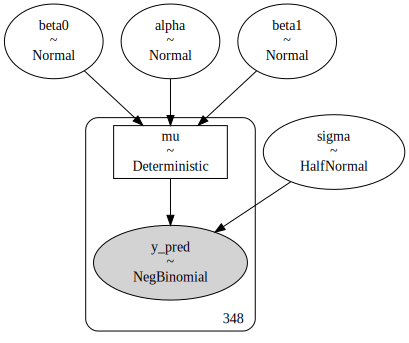

In [107]:
pm.model_to_graphviz(model_mlb)

In [109]:
ut.save_dot(model_mlb, "Lesson07_Multiple_linear_regression_model_RentedBikes_model.png")

![](lectures_source/figures/Lesson07_Multiple_linear_regression_model_RentedBikes_model)


![](lectures_source/figures/Lesson07_Multiple_linear_regression_model_RentedBikes_model_trace.png)


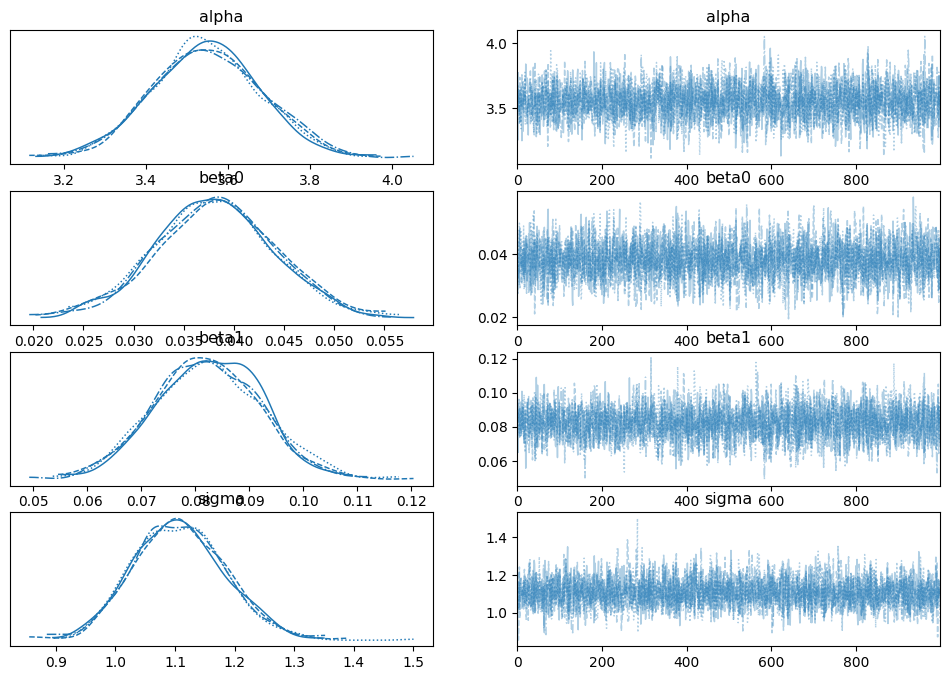

In [113]:
var_names = ["alpha", "beta0", "beta1", "sigma"]
az.plot_trace(idata_mlb, var_names=var_names);
ut.save_plt("Lesson07_Multiple_linear_regression_model_RentedBikes_model_trace.png")

In [116]:
df = az.summary(idata_mlb, var_names=var_names, round_to=2, kind="stats")
df

,mean,sd,hdi_3%,hdi_97%
alpha,3.55,0.13,3.32,3.82
beta0,0.04,0.01,0.03,0.05
beta1,0.08,0.01,0.06,0.10
sigma,1.11,0.08,0.97,1.25
